In [1]:
import json
import warnings

from pprint import pprint

import torch

from tqdm import tqdm
from torch import cuda, bfloat16

from evaluate import load

# import transformers
import transformers
from transformers import StoppingCriteria, StoppingCriteriaList

import matplotlib.pyplot as plt

# import langchain
from langchain import PromptTemplate
from langchain.llms import HuggingFacePipeline
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
    )

# import custom util functions
from evaluation_utils import evaluate

# EVALUATE THE VDB WITH MRR AND ACCURACY

## LOAD THE DATA

In [2]:
# Load Document
loader = WikipediaLoader(query= "Aristophanes")

loader.requests_kwargs = {"verify": False}

document = loader.load()

/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [3]:
# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splits = text_splitter.split_documents(document)
pprint(splits[0].page_content)

('Aristophanes (; Ancient Greek: Ἀριστοφάνης, pronounced [aristopʰánɛːs]; '
 'c.\u2009446 – c.\u2009386 BC), son of Philippus and Zenodora, of the deme '
 'Kydathenaion (Latin: Cydathenaeum), was a comic playwright or comedy-writer '
 'of ancient Athens and a poet of Old Attic Comedy. Eleven of his forty plays '
 'survive virtually complete. These provide the most valuable examples of a '
 'genre of comic drama known as Old Comedy and are used to define it, along '
 'with fragments from dozens of lost plays by Aristophanes and his')


## LOAD EVALUATION DATA

In [4]:
with open("./question_context_aristophanes.json", "r") as file:
  eval_data = json.load(file)
pprint(eval_data[0])

{'context': 'Aristophanes (; Ancient Greek: Ἀριστοφάνης, pronounced '
            '[aristopʰánɛːs]; c.\u2009446 – c.\u2009386 BC), son of Philippus '
            'and Zenodora, of the deme Kydathenaion (Latin: Cydathenaeum), was '
            'a comic playwright or comedy-writer of ancient Athens and a poet '
            'of Old Attic Comedy. Eleven of his forty plays survive virtually '
            'complete. These provide the most valuable examples of a genre of '
            'comic drama known as Old Comedy and are used to define it, along '
            'with fragments from dozens of lost plays by Aristophanes and his',
 'question1': 'Which deme is Aristophanes believed to have originated from?',
 'question2': "How many plays of Aristophanes' works are known to survive "
              'virtually complete?',
 'question3': 'What genre of comic drama is Aristophanes best known for '
              'writing?',
 'question4': 'In what century did Aristophanes live?'}


## EVALUATE DIFFERENT SETTINGS

In [5]:
search = {
    "k" : list(range(2, 11)),
    "search_type" : ["similarity", "mmr", "similarity_score_threshold"],
    "models" : ["distiluse-base-multilingual-cased-v2", "all-MiniLM-L6-v2", "all-mpnet-base-v2"],
    "thresholds" : [0.3, 0.5, 0.9],
    "docs": splits,
    "eval_data": eval_data
  }

In [6]:
result = evaluate(**search)

100%|██████████| 3/3 [17:51<00:00, 357.09s/it]


In [7]:
plt.rcParams["figure.figsize"] = (8, 6)

def plot_mrr(result: dict, method: str):
  plt.plot(list(range(2, 11)), result["all-MiniLM-L6-v2"][method]["mrr"], label="MiniLM")
  plt.plot(list(range(2, 11)), result["all-mpnet-base-v2"][method]["mrr"], label="mpnet")
  plt.plot(list(range(2, 11)), result["distiluse-base-multilingual-cased-v2"][method]["mrr"], label="distiluse")
  plt.xlabel("number or returned documents")
  plt.ylabel("mrr score")
  plt.grid()
  plt.legend()
  plt.title(f"{method} search mrr score")
  plt.savefig(f"./{method}_mrr.png")

def plot_accuracy(result: dict, method: str):
  plt.plot(list(range(2, 11)), result["all-MiniLM-L6-v2"][method]["accuracy"], label="MiniLM")
  plt.plot(list(range(2, 11)), result["all-mpnet-base-v2"][method]["accuracy"], label="mpnet")
  plt.plot(list(range(2, 11)), result["distiluse-base-multilingual-cased-v2"][method]["accuracy"], label="distiluse")
  plt.xlabel("number or returned documents")
  plt.ylabel("occurence ratio")
  plt.grid()
  plt.legend()
  plt.title(f"{method} search correct doc occurence")
  plt.savefig(f"./{method}_doc_occurence.png")

def plot_thresholded(results: dict, method: str, score: str, model: str, threshold: float):
  plt.plot(list(range(2, 11)), result[model]["similarity_score_threshold"][str(threshold)][score], label=f"similarity {threshold} threshold")
  plt.plot(list(range(2, 11)), result[model][method][score], label=method)
  plt.xlabel("number of returned documents")
  plt.ylabel("mrr score")
  plt.grid()
  plt.legend()
  plt.title(f"{score} score with {threshold} threshold")
  plt.savefig(f"./{method}_vs_{threshold}_threshold_{score}_doc_occurence.png")

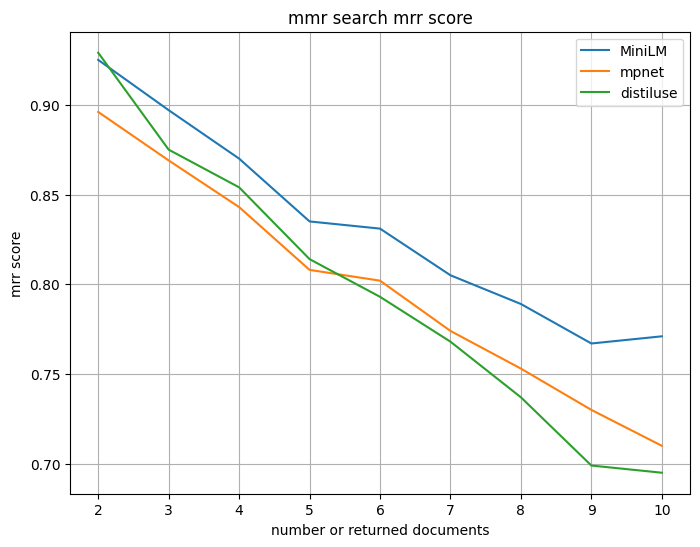

In [8]:
plot_mrr(result, "mmr")

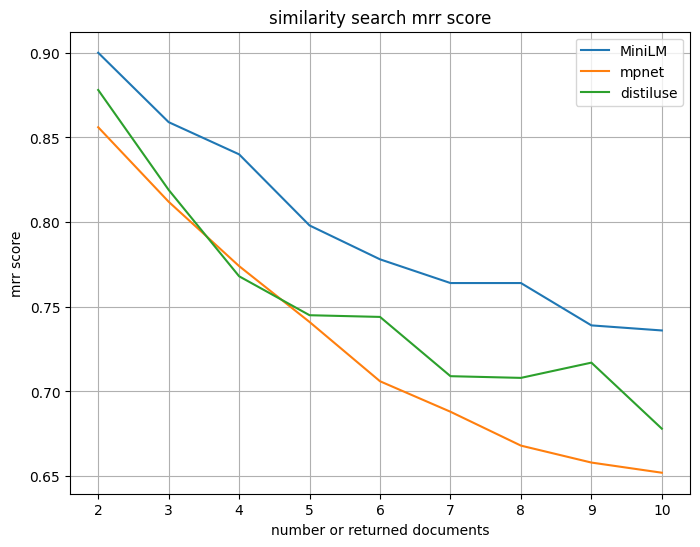

In [9]:
plot_mrr(result, "similarity")

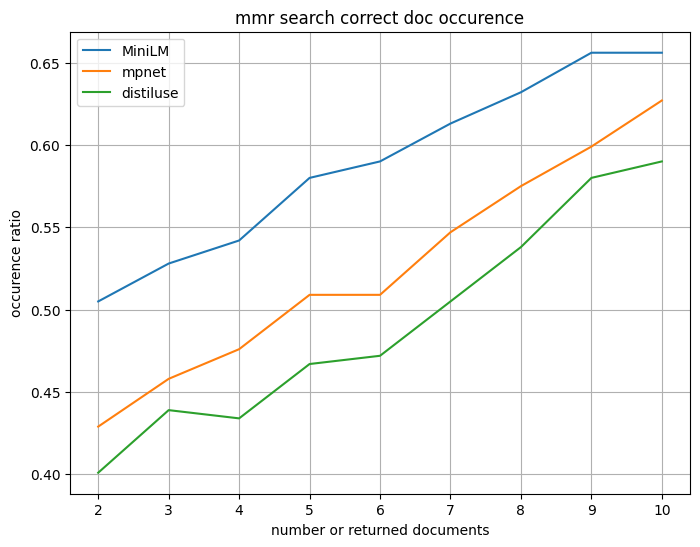

In [10]:
plot_accuracy(result, "mmr")

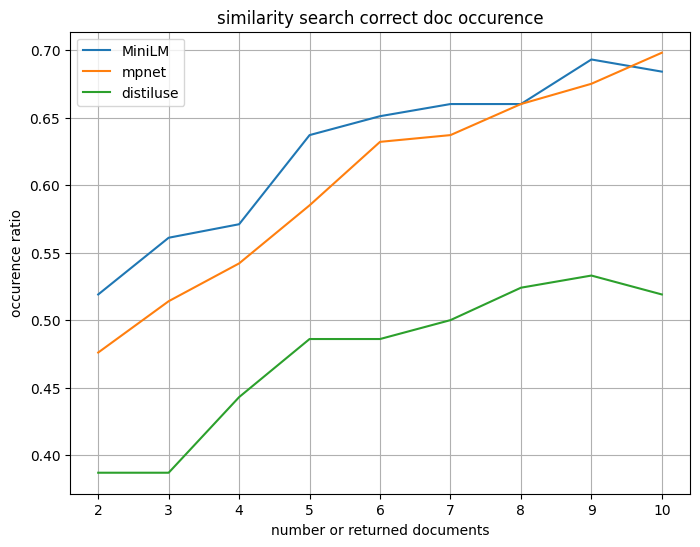

In [11]:
plot_accuracy(result, "similarity")

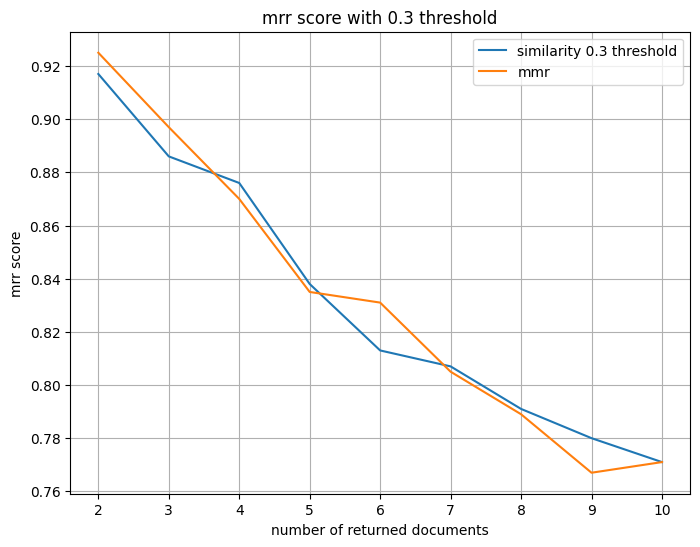

In [12]:
plot_thresholded(results=result, method="mmr", score="mrr", model="all-MiniLM-L6-v2", threshold=0.3)

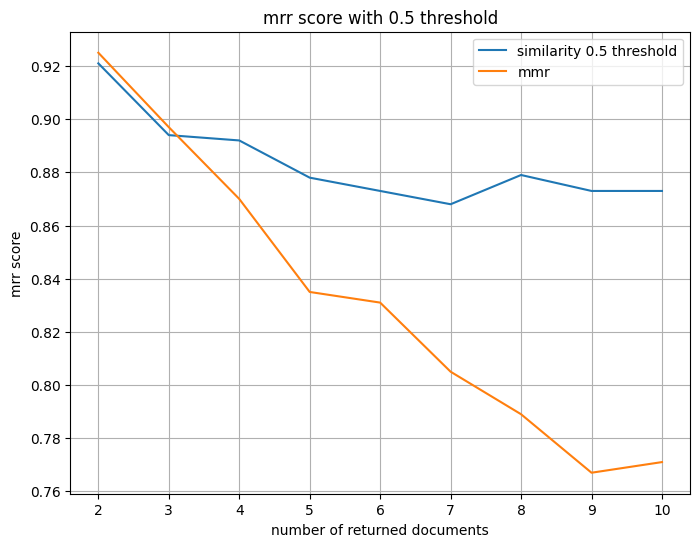

In [13]:
plot_thresholded(results=result, method="mmr", score="mrr", model="all-MiniLM-L6-v2", threshold=0.5)

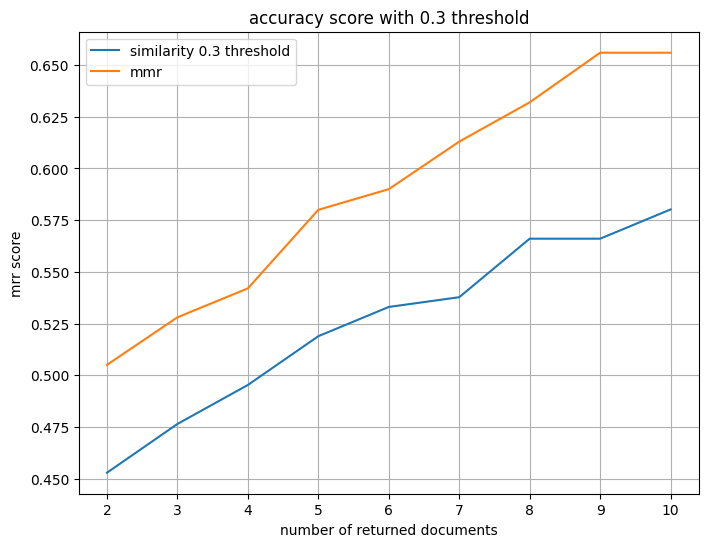

In [14]:
plot_thresholded(results=result, method="mmr", score="accuracy", model="all-MiniLM-L6-v2", threshold=0.3)

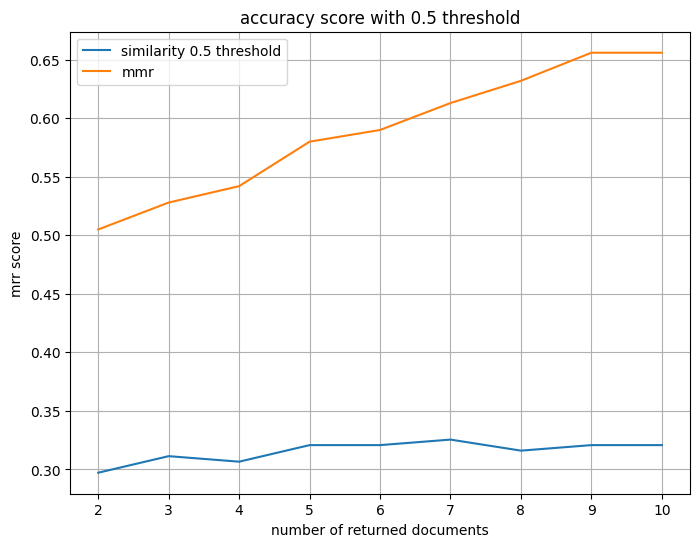

In [15]:
plot_thresholded(results=result, method="mmr", score="accuracy", model="all-MiniLM-L6-v2", threshold=0.5)

# EVALUATE THE RESPONSE WITH ROUGE AND BLEU SCORE

In [2]:
# the model and tokenizer for the generation
LLM_MODEL="mistralai/Mistral-7B-Instruct-v0.2"
LLM_TOKENIZER="mistralai/Mistral-7B-Instruct-v0.2"
# placeholder for an embedding function
embedding_function=None
# set device to GPU if available
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

In [3]:
EMBED_MODEL="all-MiniLM-L6-v2"

## LOAD THE DATA (IF NOT ALREADY LOADED)

In [4]:
try:
  pprint(document[0].page_content[:200])
except:
  # Load Document
  loader = WikipediaLoader(query= "Aristophanes")

  loader.requests_kwargs = {"verify": False}

  document = loader.load()

  # Split
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
  splits = text_splitter.split_documents(document)
  pprint(splits[0].page_content)

/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


('Aristophanes (; Ancient Greek: Ἀριστοφάνης, pronounced [aristopʰánɛːs]; '
 'c.\u2009446 – c.\u2009386 BC), son of Philippus and Zenodora, of the deme '
 'Kydathenaion (Latin: Cydathenaeum), was a comic playwright or comedy-writer '
 'of ancient Athens and a poet of Old Attic Comedy. Eleven of his forty plays '
 'survive virtually complete. These provide the most valuable examples of a '
 'genre of comic drama known as Old Comedy and are used to define it, along '
 'with fragments from dozens of lost plays by Aristophanes and his')


## LOAD THE EMBEDDING MODEL AND THE ENCODE THE DATA IN THE DB

In [5]:
# load the model wrapped as an embedding function
embedding_function = SentenceTransformerEmbeddings(model_name=EMBED_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
# encode and load the data into Chroma
db = Chroma(collection_name=EMBED_MODEL)
db = Chroma.from_documents(splits, embedding_function)

## PREPARE THE MODEL

In [7]:
# load the model
model = transformers.AutoModelForCausalLM.from_pretrained(LLM_MODEL, trust_remote_code=True, torch_dtype=bfloat16)
# set it to evaluation mode
model.eval()
# assign it to the available device
model.to(device)

# load the tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(LLM_TOKENIZER)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
# mistral is trained to add "</s>" at the end of generations
stop_token_ids = tokenizer.convert_tokens_to_ids(["</s>"])

# define custom stopping criteria object
class StopOnTokens(StoppingCriteria):
  def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
    for stop_id in stop_token_ids:
      if input_ids[0][-1] == stop_id:
        return True
    return False

stopping_criteria = StoppingCriteriaList([StopOnTokens()])

In [9]:
generate_text = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    return_full_text=True, # langchain expects the full text
    task='text-generation', device=device, # we pass model parameters here too
    stopping_criteria=stopping_criteria, # without this model will ramble
    temperature=0.1, # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    top_p=0.15, # select from top tokens whose probability add up to 15%
    top_k=0, # select from top 0 tokens (because zero, relies on top_p)
    max_new_tokens=512, # max number of tokens to generate in the output
    repetition_penalty=1.1, # without this output begins repeating
    do_sample=True,
    pad_token_id=tokenizer.eos_token_id
    )

prompt = PromptTemplate(input_variables=["instruction"], template="{instruction}")
llm = HuggingFacePipeline(pipeline=generate_text)

## DEFINE THE PROMPT

In [10]:
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If the answer is not presented, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

## LOAD EVAL DATA

In [11]:
with open("./context_question_answer_triplets_aristophanes.json", "r") as file:
  eval_data = json.load(file)
pprint(eval_data[0])

{'answer': 'Aristophanes',
 'context': 'and are used to define it, along with fragments from dozens of '
            'lost plays by Aristophanes and his contemporaries.Also known as '
            '"The Father of Comedy" and "the Prince of Ancient Comedy", '
            'Aristophanes has been said to recreate the life of ancient Athens '
            'more convincingly than any other author. His powers of ridicule '
            'were feared and acknowledged by influential contemporaries; Plato '
            "singled out Aristophanes' play The Clouds as slander that "
            'contributed to the trial and subsequent condemning to death',
 'question': "Who is considered the 'Father of Comedy' and 'Prince of Ancient "
             "Comedy' in Greek literature?"}


## LOAD METRICS

In [12]:
rouge = load('rouge')
bleu = load('bleu')

## DEFINE THE CHAIN (ORIGINAL PARAMETERS)

In [13]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# chain
rag_chain = (
    {"context": db.as_retriever(k=5) | format_docs,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

## RUN CHAIN

In [14]:
warnings.filterwarnings("ignore")

answers = []
responses = []
sources = []

for sample in tqdm(eval_data):
  question = sample["question"]
  answers.append(sample["answer"])
  sources.append(sample["context"])
  responses.append(rag_chain.invoke(question))

100%|██████████| 105/105 [14:15<00:00,  8.15s/it]


## EVALUATE

In [15]:
rouge_response_answer = rouge.compute(predictions=responses, references=answers)
print(rouge_response_answer)

{'rouge1': 0.38524275342060643, 'rouge2': 0.20920251341550858, 'rougeL': 0.3026399367818365, 'rougeLsum': 0.30468027538894493}


In [16]:
rouge_response_context = rouge.compute(predictions=responses, references=sources)
print(rouge_response_context)

{'rouge1': 0.3659025236116279, 'rouge2': 0.15155402583838606, 'rougeL': 0.2570395888909405, 'rougeLsum': 0.2619902225544648}


In [17]:
bleu_response_answer = bleu.compute(predictions=responses, references=answers)
print(bleu_response_answer)

{'bleu': 0.1418736887296626, 'precisions': [0.3292910447761194, 0.1587059942911513, 0.10485436893203884, 0.07393458870168483], 'brevity_penalty': 1.0, 'length_ratio': 1.4529682840878286, 'translation_length': 5360, 'reference_length': 3689}


In [18]:
bleu_response_context = bleu.compute(predictions=responses, references=sources)
print(bleu_response_context)

{'bleu': 0.09039767358376298, 'precisions': [0.4369402985074627, 0.16232159847764036, 0.08970873786407767, 0.05609514370664024], 'brevity_penalty': 0.6576845625997906, 'length_ratio': 0.704706810412832, 'translation_length': 5360, 'reference_length': 7606}


## DEFINE THE NEW CHAIN (NEW PARAMETERS)

In [13]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# chain
rag_chain = (
    {"context": db.as_retriever(k=10, search_type="mmr") | format_docs,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

## RUN NEW CHAIN

In [14]:
warnings.filterwarnings("ignore")

answers = []
responses = []
sources = []

for sample in tqdm(eval_data):
  question = sample["question"]
  answers.append(sample["answer"])
  sources.append(sample["context"])
  responses.append(rag_chain.invoke(question))

100%|██████████| 105/105 [13:39<00:00,  7.81s/it]


## EVALUATE

In [15]:
rouge_response_answer = rouge.compute(predictions=responses, references=answers)
print(rouge_response_answer)

{'rouge1': 0.39256403277587804, 'rouge2': 0.22169073640616474, 'rougeL': 0.31114566481240147, 'rougeLsum': 0.31192732532493506}


In [16]:
rouge_response_context = rouge.compute(predictions=responses, references=sources)
print(rouge_response_context)

{'rouge1': 0.36031445388846706, 'rouge2': 0.14846490721421562, 'rougeL': 0.25026400530471005, 'rougeLsum': 0.25248204056264917}


In [17]:
bleu_response_answer = bleu.compute(predictions=responses, references=answers)
print(bleu_response_answer)

{'bleu': 0.1569940540155321, 'precisions': [0.3421405322611526, 0.1742868307932786, 0.11709555156592859, 0.08700081499592502], 'brevity_penalty': 1.0, 'length_ratio': 1.4158308484684197, 'translation_length': 5223, 'reference_length': 3689}


In [18]:
bleu_response_context = bleu.compute(predictions=responses, references=sources)
print(bleu_response_context)

{'bleu': 0.08991897586697206, 'precisions': [0.43806241623587977, 0.16256350136772177, 0.09315778974665868, 0.061124694376528114], 'brevity_penalty': 0.6336546451935114, 'length_ratio': 0.6866947146989218, 'translation_length': 5223, 'reference_length': 7606}
